In [89]:
import h5py
import numpy as np
import pandas as pd
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_theme(context='paper',palette=sns.color_palette("tab10"),style='white',font_scale=1.5,font='serif')


def image_extraction(filename:str) -> tuple[np.array, pd.DataFrame]:
    """Extract images aswell as the foldless dataset. The indeces will match between ds and image array, but not ID."""
    dataset = h5py.File(filename, 'r')
    ds = pd.DataFrame()
    for i, fold in enumerate(dataset.keys()):
        print(dataset[fold])
        df=pd.DataFrame({'ID':np.array(dataset[fold]['patient_idx']),'target':np.array(dataset[fold]['y']),'diagnosis':np.array(dataset[fold]['diagnosis']),'fold':i})
        ds=pd.concat([ds,df],ignore_index=True,axis=0,keys=['','fold {}'.format(fold)]) # ignore index to match index with image indeces
    #ds.set_index("ID", inplace = True)

    images=np.array(dataset['fold_0']['x']) # Image index corresponds to gen_dataset index, i.e., the ID in the ds
    images = np.append(images,np.array(dataset['fold_1']['x']),axis=0)
    images=np.append(images,np.array(dataset['fold_2']['x']),axis=0)
    images=np.append(images,np.array(dataset['fold_3']['x']),axis=0)
    images=images.reshape(len(images),800,800)
    dataset.close()
    
    return images, ds


def test_result_extraction(filename,ds,external=False):
    """Parameters:
    -----------
    filename : str
        Path to the HDF5 file containing the prediction results.
    ds: pandas.DataFrame
        The original dataframe

    Returns:
    --------
    pandas.DataFrame
        A DataFrame containing the predicted values, true labels and probabilities for each patient.
        The index of the testset-DataFrame is the ID of the original ds. df.index=ds.ID
    """

    diagnoses=['normal','1, artrose/\nsklerose','2, artrose', '2, mistanke\n MCD',
            '3, artrose', '3, MCD', '3, OCD', '3, UAP']
    
    
    # Open the HDF5 file and extract the necessary data
    f = h5py.File(filename, 'r')
    print('extracting predicted test set')
    pred = np.array(f['predicted'][:])
    patient = np.array(f['patient_idx'][:])
    y = np.array(f['y'][:])
    f.close()

    # Create a DataFrame with the extracted data
    df = pd.DataFrame({'pred':pred.flatten(),'label': y.flatten()},index=patient)

    # Add a column for the predicted probabilities rounded to two decimal places
    df['prob']=np.round(df['pred'],2)

    # Round the predicted values to the nearest integer
    df['pred']=np.round(df['pred'],0)

    # Need to match test fold and predictions by ID, since indeces don't match
    if external == False:
        test_ds = ds.loc[ds.fold==3.0].sort_values('ID')
        
    else:
        test_ds=ds.sort_values('ID')

    test_ds=test_ds.assign(prob=df.sort_index().prob.values,
            pred=df.sort_index().pred.values)
    
    for d in np.unique(test_ds.diagnosis):
        test_ds.diagnosis[test_ds.diagnosis==d]=diagnoses[int(d)]
        print(d, diagnoses[int(d)])

    return test_ds


       
def check_wrong(df, show_images=True, images=None):
    """
    df: the .h5 file of the test result
    """
    diagnoses=['normal','1, artrose/\nsklerose','2, artrose', '2, mistanke\n MCD',
            '3, artrose', '3, MCD', '3, OCD', '3, UAP']
    wrong=df.iloc[np.where(df['pred'].values!=df['target'])[0]].index

    


    df['Feilpredikert']= 'Nei'
    df.loc[wrong,('Feilpredikert')] = 'Ja'

    df_wrong = df[df.Feilpredikert=='Ja']
    df_wrong = df_wrong.drop(['Feilpredikert'],axis=1)

    plt.figure()
    confusion_matrix=sklearn.metrics.confusion_matrix(df['target'],df['pred'])
    #cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, 
    #                                                    display_labels = ['normal','abnormal'])
    #cm_display.plot()
    sns.heatmap(confusion_matrix,annot=True, fmt="d", linewidths=.5)
    plt.xticks([0.5,1.5],['Normal','Abnormal'])
    plt.yticks([0.5,1.5],['Normal','Abnormal'])
    plt.title('Forvirringsmatrise med absolutte tall')
    plt.xlabel('Predikert klasse')
    plt.ylabel('Sann klasse')
    plt.show()

    plt.figure()
    confusion_matrix=sklearn.metrics.confusion_matrix(df['target'],df['pred'], normalize='true')
    #cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,
    #                                                    display_labels = ['normal','abnormal'])
    sns.heatmap(confusion_matrix,annot=True, linewidths=.5)
    plt.xticks([0.5,1.5],['Normal','Abnormal'])
    plt.yticks([0.5,1.5],['Normal','Abnormal'])
    plt.title('Normalisert forvirringsmatrise') #(normalisert over sann diagnose)
    plt.xlabel('Predikert klasse')
    plt.ylabel('Sann klasse')
    plt.show()

    # plt.figure()
    # plt.title('Feilklassifiserte prøver')
    # sns.histplot(df[df.Feilpredikert=='Ja'], x='prob', bins=100, stat="proportion")
    # plt.ylabel('Andel')
    # plt.xlabel('Predikert sannsynlighet for abnormalitet')

    plt.figure()
    sns.stripplot(data=df_wrong,x='pred',y='prob',jitter=True,hue='diagnosis',palette="bright")
    plt.legend(title='Sann klasse',loc='right', bbox_to_anchor=(1.2, 0.3),
            ncol=1, fancybox=True)
    sns.violinplot(x=df_wrong['pred'],y=df_wrong['prob'],color="0.8",scale="count")
    plt.xticks([0,1],['normal','abnormal'])
    plt.yticks(np.arange(0,1.05,0.2))
    plt.xlabel('Predikert klasse')
    plt.ylabel('Predikert sannsynlighet')
    plt.show()

    plt.figure()
    sns.stripplot(data=df[df.Feilpredikert=='Nei'],x='pred',y='prob',jitter=True,hue='diagnosis',palette="bright")
    plt.legend(title='Sann klasse',loc='right', bbox_to_anchor=(1.2, 0.4),
            ncol=1, fancybox=True)
    sns.violinplot(x=df.pred[df.Feilpredikert=='Nei'],y=df.prob[df.Feilpredikert=='Nei'],color="0.8",scale="count")
    plt.xticks([0,1],['normal','abnormal'])
    plt.yticks(np.arange(0,1.05,0.2))
    plt.xlabel('Predikert klasse')
    plt.ylabel('Predikert sannsynlighet')
    plt.show()

    # plt.figure()
    # plt.title('Rett predikerte prøver')
    # sns.histplot(df[df.Feilpredikert=='Nei'], x='prob', bins=100,stat='proportion')
    # plt.ylabel('Andel')
    # plt.xlabel('Predikert sannsynlighet for abnormalitet')

    fig, ax = plt.subplots()
    sns.histplot(x='diagnosis',data=df,stat='density',
                 common_norm=True, 
                 hue='Feilpredikert',
                 discrete=True,
                 multiple="dodge", 
                 shrink=.8,ax=ax) # Bruker originalt datasett for å få alle diagnosene
    plt.xticks(rotation=45)
    plt.ylabel('Andel')
    ax2 = plt.twinx()
    hist=sns.histplot(x='diagnosis',data=df,stat='count',
                 common_norm=True, 
                 hue='Feilpredikert',
                 discrete=True,
                 multiple="dodge", 
                 shrink=.8,ax=ax2)
    plt.ylabel('Antall',rotation=-90)
    hist.bar_label(hist.containers[0])
    hist.bar_label(hist.containers[1])
    sns.despine(top=True,right=False)
    plt.grid(True)
    plt.xlabel('Sann diagnose')
    plt.show()

    diagnoses=['normal','1, artrose/sklerose','2, artrose', '2, mistanke MCD',
            '3, artrose', '3, MCD', '3, OCD', '3, UAP']
    if show_images==True:
        for i in wrong:
            print('ID: ',df.ID[i],'\n index: ',i)
            plt.figure()
            plt.imshow(images[i],'gray')
            plt.axis('off')
            plt.title('Sann diagnose: {},\n Predikert sannsynlighet: {:.2f}'.format(
                                                                    df.diagnosis[i],
                                                                    df.prob[i]))
            plt.show()
                
    
    return df_wrong

In [85]:
images, ds = image_extraction('//nmbu.no/Research/Project/CubiAI/preprocess/datasets/800_normal_abnormal_2.h5') # 800_ext_binary_2 / 800_normal_abnormal_2
df = test_result_extraction('prediction11939790.h5',ds,external=False) # prediction11939790 / prediction11810679 / prediction_external


<HDF5 group "/fold_0" (4 members)>
<HDF5 group "/fold_1" (4 members)>
<HDF5 group "/fold_2" (4 members)>
<HDF5 group "/fold_3" (4 members)>
extracting predicted test set
0.0 normal
1.0 1, artrose/
sklerose
2.0 2, artrose
3.0 2, mistanke
 MCD
4.0 3, artrose
5.0 3, MCD
6.0 3, OCD
7.0 3, UAP


C:\NMBU\TEMP\ipykernel_15712\958911914.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_ds.diagnosis[test_ds.diagnosis==d]=diagnoses[int(d)]


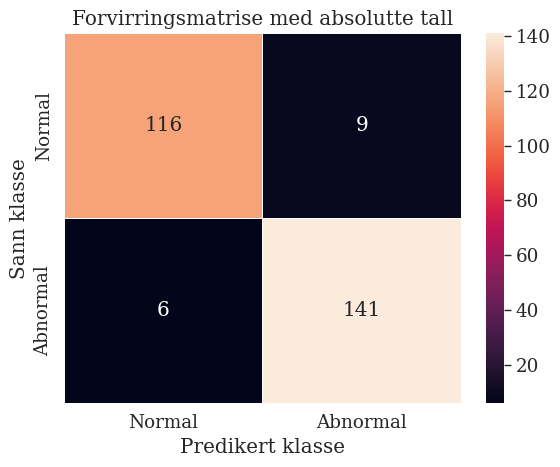

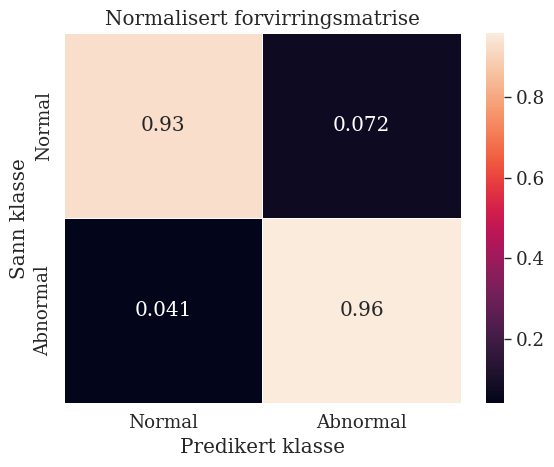

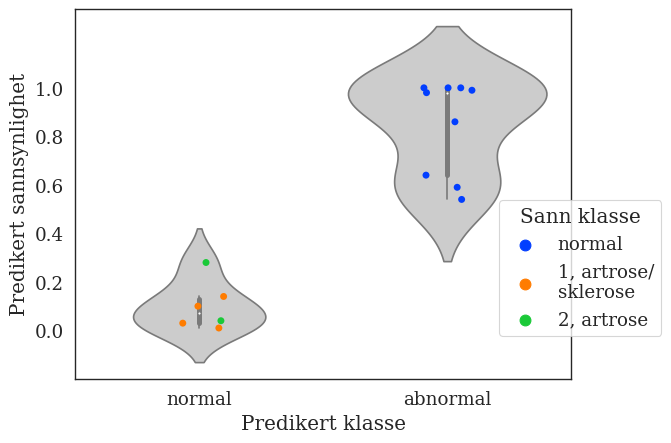

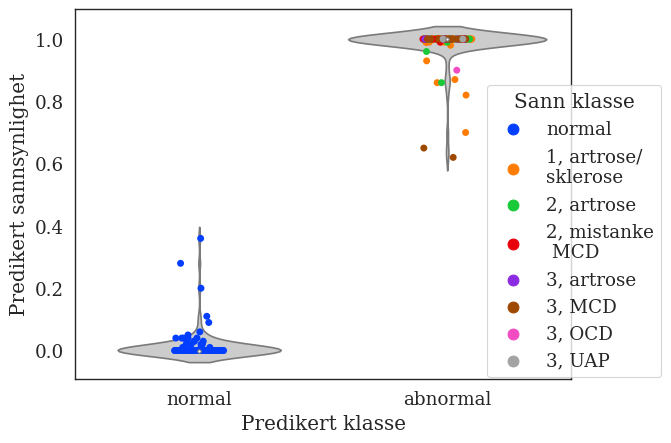

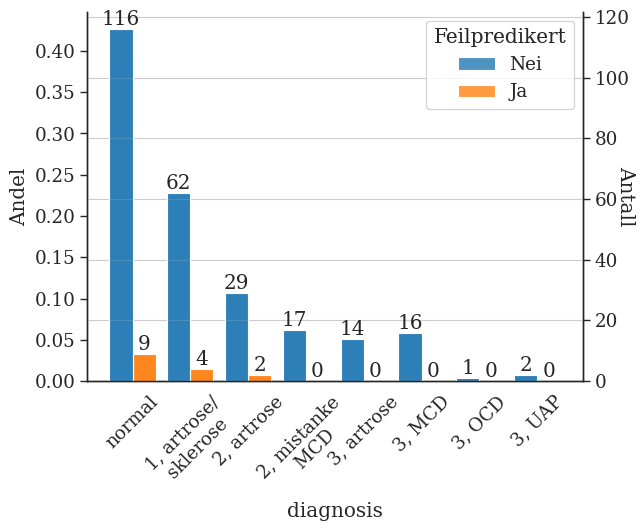

ID:  40.0 
 index:  988


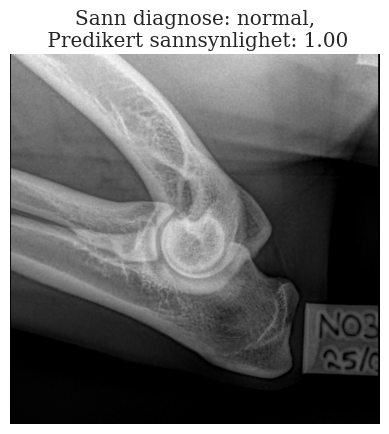

ID:  126.0 
 index:  1009


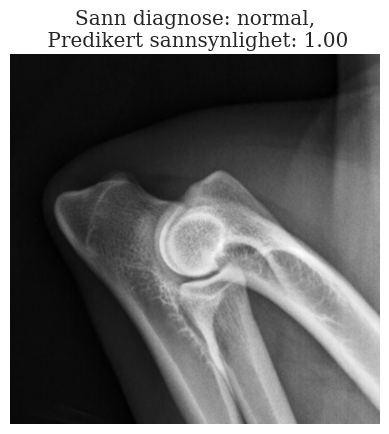

ID:  154.0 
 index:  1048


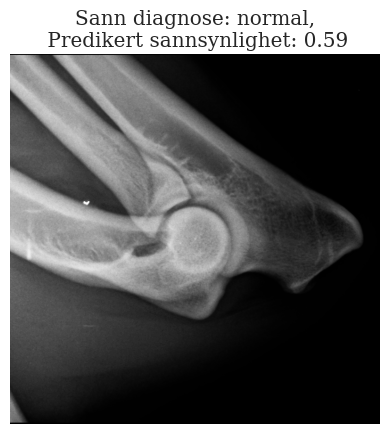

ID:  272.0 
 index:  946


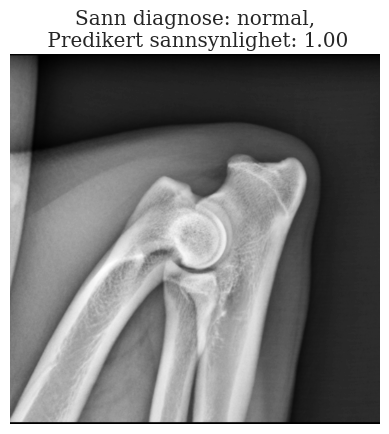

ID:  282.0 
 index:  938


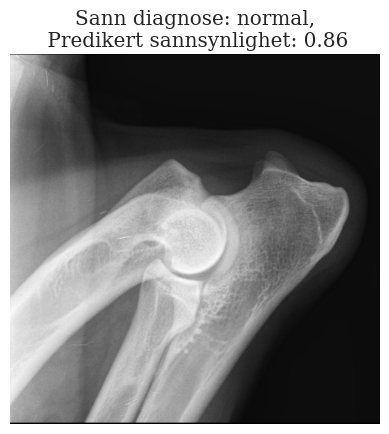

ID:  340.0 
 index:  980


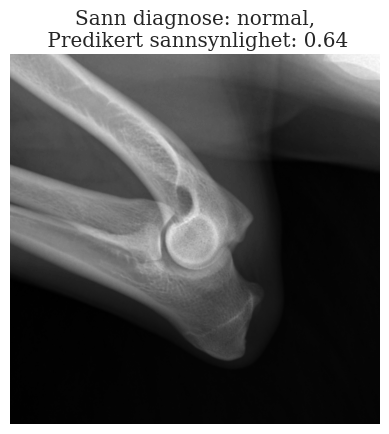

ID:  406.0 
 index:  1083


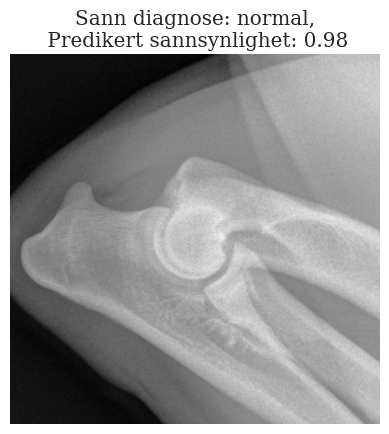

ID:  434.0 
 index:  1069


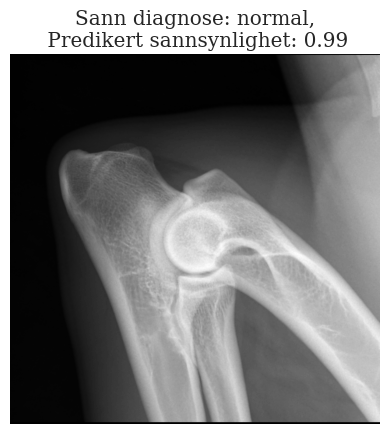

ID:  481.0 
 index:  1035


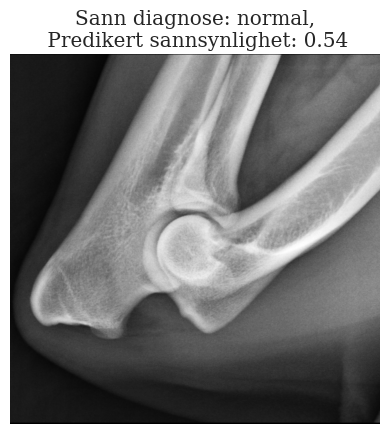

ID:  619.0 
 index:  917


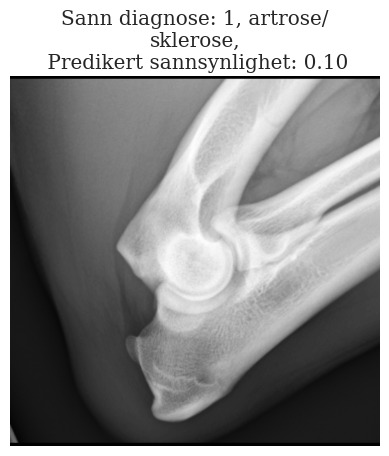

ID:  685.0 
 index:  963


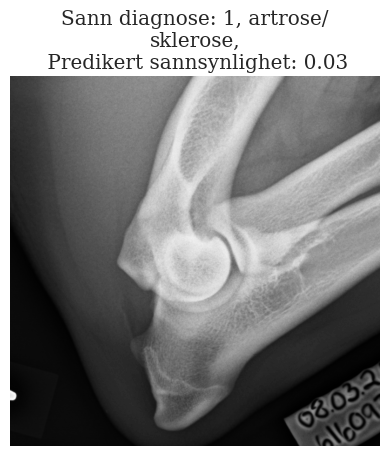

ID:  705.0 
 index:  1040


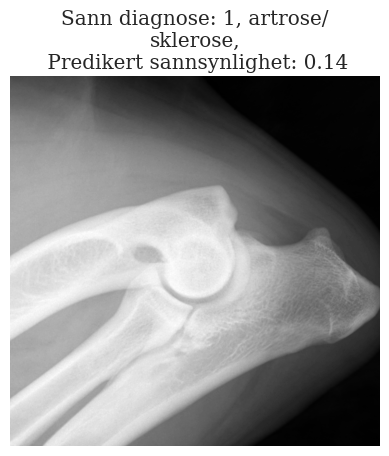

ID:  724.0 
 index:  997


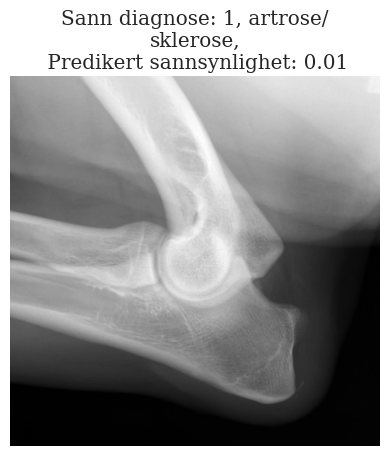

ID:  760.0 
 index:  927


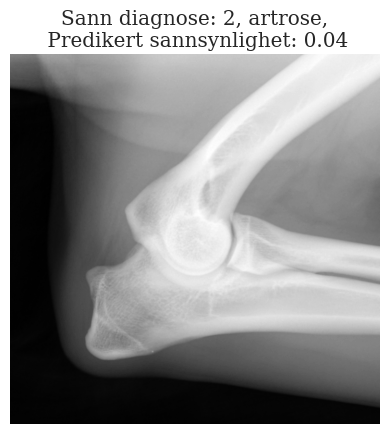

ID:  847.0 
 index:  900


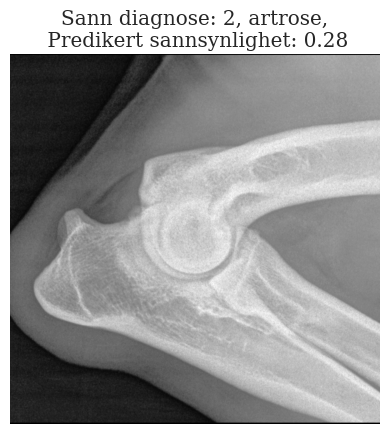

In [91]:
df_wrong=check_wrong(df,True,images)

Fetching all datasets of test data and making one dataframe of all of them, then closing the file.